<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/13_Ultra_Light_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

Самостоятельно обучите нейросеть по классификации текстов писателей. 

Для этого нужно предварительно написать обработку данных, разделение датасета «скользящим окном», саму нейросеть. Можно подглядывать в ноутбук занятия, однако код следует писать самому - без копирования.

# Import of libraries

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer  #Метод для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences #Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder #Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split #Метод для разделения выборки на обучающую и тестовую

from google.colab import drive
import time #Импортируем библеиотеку time

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Classification of writter's texts

Loading data

In [ ]:
#Проверяем папку с текстами , если она есть , удаляем
!rm - R '/content/texts' 

rm: cannot remove '-': No such file or directory
rm: cannot remove 'R': No such file or directory
rm: cannot remove '/content/texts': No such file or directory


In [ ]:
#Указываем путь к базе в гугл диск и создаем папку texts и извлекаем туда базу
!unzip -q '/content/texts.zip' -d '/content/texts' #метод не сработал, ссылка была на незазипованную базу
# загрузила вручную

In [ ]:
#Собираем данные через функцию, которая читает данные
#На вход подаем путь к файлу, открываем файл в режиме чтения
# переносы строки меняем на пробелы
# возвращаем текст файла
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace('\n', ' ')

  return text

# Объявляем классы и считаем кол-во классов
className = ['О. Генри', 'Стругацкие', 'Булгаков', ' Саймак', 'Фрай', 'Брэдберри']
nClasses = len(className)

# Итак, мы растянули весь текст в одну строку

In [ ]:
#Загружаем обучающие тексты

trainText = []
testText = []

#Создаем выборку по условию:
#Класс каждого i-го элемента в обучающей выборке должен соответствовать
#классу каждого i-го элемента тестовой выборки

# Обходим классы
for i in className:
  # пробегаемся по всем документам в папке 'texts'
  for j in os.listdir('texts/'):
    # смотрим содержится ли в названии имя класса, если да , то работаем дальше
    if i in j:
      # Дальше проверяем обучающий это файл или тестовый и добавляем текст в выборку
      if 'Обучающая' in j:
        trainText.append(readText('texts/' + j))
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText('texts/' + j))
        print(j, 'добвлен в тестовую выборку')
print()

      

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добвлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Булгаков) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд Саймак) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добвлен в тестовую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добвлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
# Посмотрим кол-во элементов в trainText и в первом элементе 
print(len(trainText))
print(len(trainText[0]))

6
1049517


In [ ]:
# Посмотрим кол-во элементов в testText и в первом элементе 
print(len(testText))
print(len(testText[0]))

6
349662


# Data processing. Converting textual data to numeric and vector for neural network training

In [ ]:
#Tokenizer - функция Keras , которая поможет разделить текст и преобразовать его в матрицу числовых значений
# засекаем время
cur_time = time.time()
#Для русского языка часто используется параметр 20 000 - кол-во слов/индексов при обучении текста
maxWordsCount = 20000
#Избавимся от ненужных символов, приводим слова к нижнему регистру и char_level = False - токенизируем по словам
tokenizer = Tokenizer(num_words=maxWordsCount, filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower = True, split=' ', oov_token='unknown', char_level = False)

# Подаем тексты в обработку
tokenizer.fit_on_texts(trainText)
#Выводим интексы слов для просмотра
items = list(tokenizer.word_index.items())
print('Время обработки: ', round(time.time()-cur_time, 2), 'c', sep='')





Время обработки: 3.35c


In [ ]:
# посмотрим первые 120 часто встречающихся слов
print(items[:120])
print('Размер словаря: ', len(items))

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('бы', 27), ('сказал', 28), ('вы', 29), ('было', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('вот', 39), ('когда', 40), ('если', 41), ('уже', 42), ('был', 43), ('нет', 44), ('ни', 45), ('их', 46), ('ну', 47), ('чтобы', 48), ('до', 49), ('для', 50), ('ему', 51), ('ничего', 52), ('может', 53), ('или', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('чем', 63), ('него', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('ли', 72), ('время', 73), ('тебе', 74), ('вас', 75), ('со', 76), ('нибудь', 77), ('

In [ ]:
# протестируем словарь частотности
print('Интересующее слово имет индекс: ', tokenizer.word_index[input('Уточните слово: ')])

Уточните слово: и
Интересующее слово имет индекс:  2


In [ ]:
# заменяем слова на индексы - преобразуем текст к числовым значениям
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

print('Взглянем на фрагмент обучающего текста: ')
print('В виде оригинального текста:                ', trainText[1][:87])
print('Он же в виде последовательности индексов:   ', trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста: 
В виде оригинального текста:                 Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:    [473, 22, 1, 1508, 47, 2, 12834, 7800, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 9472] 



In [ ]:
print('Статистика по обучающим текстам  :')

#Посчитаем слова и символы, для этого объявим переменные
symbolsTrainText = 0
wordsTrainTexts = 0

#обходим все классы, печатаем сколько символов в примере и сколько слов
for i in range(nClasses):
  print(className[i], ' '*(10-len(className[i])), len(trainText[i]), 'символов, ',len(trainWordIndexes[i]), 'слов')
  symbolsTrainText += len(trainText[i])
  wordsTrainTexts += len(trainWordIndexes[i])

print('----')
print('В сумме ', symbolsTrainText, 'символов', wordsTrainTexts, 'слов \n')
print()
print("Статистика по тестовым текстам: ")

symbolsTestText = 0
wordsTestText = 0 

for i in range(nClasses):
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), 'символов, ', len(testWordIndexes[i]), 'слов')
  symbolsTestText += len(testText[i])
  wordsTestText += len(testWordIndexes[i])
print('----')
print('В сумме ', symbolsTestText, 'символов, ', wordsTestText, 'слов')



Статистика по обучающим текстам  :
О. Генри    1049517 символов,  160607 слов
Стругацкие  2042469 символов,  313012 слов
Булгаков    1765648 символов,  261465 слов
 Саймак     1609507 символов,  251502 слов
Фрай        3700010 символов,  568533 слов
Брэдберри   1386454 символов,  214454 слов
----
В сумме  11553605 символов 1769573 слов 


Статистика по тестовым текстам: 
О. Генри    349662 символов,  53238 слов
Стругацкие  704846 символов,  108621 слов
Булгаков    875042 символов,  132730 слов
 Саймак     318811 символов,  50360 слов
Фрай        1278191 символов,  196731 слов
Брэдберри   868673 символов,  132524 слов
----
В сумме  4395225 символов,  674204 слов


# Creation of training and validation samples

In [ ]:
# Напишем функцию, которая получает последовательность индексов, шаг и ширину.
# В xSample заносим примеры
# В wordsLen считаем кол-во символов
# В цикле while будем "откусывать" кусочки из wordIndexes длиной xLen
# По списку индексов слов разделяем на короткие векторы.
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step

  return xSample

# Это функция для одного писателя , а у нас их 6


In [ ]:
# Для этого создаем функцию createSetsMultyClasses, на вход подаем последовательность индексов, размер окна, шаг окна
def createSetsMultiClasses(wordIndexes, xLen, step):
  #Для каждого из 6 классов создаем обучающую и проверочную выборки
  nClasses = len(wordIndexes)
  classesXSamples = []
  # Для каждого текста из последовательности выборки
  for wI in wordIndexes:
    #добавляем в список очередной текст индексов разбиный на (кол-во окон * длину окна)
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  #Создаем один общий xSamples 
  # список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  xSamples = []
  # список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  ySamples = []

  #В диапазоне кол-ва классов (6)
  for t in range (nClasses):
    # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    xT = classesXSamples[t]
    # И каждое его окно добавляем в общий список выборки
    for i in range(len(xT)):
      xSamples.append(xT[i])
      # Добавляем соответствующий вектор класса
      ySamples.append(utils.to_categorical(t, nClasses))

  # переводим в массив для подачи в нейронку
  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
  
  #Функция возвращает выборку и соответствующие векторы классов
  return (xSamples, ySamples)



In [ ]:
#Задаем параметры переменным 
#Длина отрезка текста, по которой анализируем, в словах
xLen = 1000 
#Шаг разбиения исходного текста на обучающие векторы
step = 100 

In [ ]:
#Засекаем текущее время
cur_time = time.time()
#извлекаем обучающую и тестовую выборки
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
print('Время обработки : ', round(time.time() - cur_time, 2), 'c', sep='')
#Получили тестовый набор, для Embedding этого достаточно. А для bag of words нужно xTrain и xTest преобразовать в векторы из 0 и 1


(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки : 4.03c


In [ ]:
print(xTrain[0])

[ 4725     7  2449  1757     1     3     1     1    11     1  7581     3
  3274     1     1   272  1057    16   259  2150     7     1     1   644
     9  2552     1     1     3  1652  7931  9662   952    11    27    55
     1   133   130     1   122  1409  3211     1   907     1  1158 15510
     1    36   193     1    63     1  2609  4726     1   953     1  1891
     1  2927     3     1 10220     2     1 17013     1   221     1     1
    11 15511     1   145   721     1     1     1   593   272     1     2
     1  1934     1  6737    17     1     1   371 14307    78    15  1460
     1  7932 10855  1200     7     1     1     1     1  7932     1  8682
  7582    50    64     1 14308  2656   246   272  4242    80  2414 11508
     4   743  3362     3  1757  4243  4727     8  8288     1     1  1310
  6255  2121     1   917   281     1  7010   336  7011   221 12294    17
     1   144 11508   886     8  6738  9134  5561  4861    31  4591     1
     2     1  1217     1 13217  3824     7  7267   

In [ ]:
# Функция sequences_to_matrix переведет наши данные в векторы со значениями 0 и 1
#Засекаем время 
cur_time = time.time()
#в виде списка, чтобы метод успешно сработал
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

print(xTrain01.shape)
print(xTrain01[0][0:100])
print('Время обработки: ', round(time.time() - cur_time,2), 'c', sep='')


(17640, 20000)
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1.]
Время обработки: 15.1c


# Creation and training of a neural network

In [ ]:
#Создаём полносвязную сеть
model = Sequential()
#Первый полносвязный слой на вход подаем максимальное кол-во слов = 20 000
model.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Слой пакетной нормализации
model.add(BatchNormalization())
#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               4000200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1206      
Total params: 4,002,206
Trainable params: 4,001,806
Non-trainable params: 400
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 12s 75ms/step - loss: 0.0448 - accuracy: 0.9865 - val_loss: 0.3922 - val_accuracy: 0.8839
Epoch 2/10
138/138 [==============================] - 10s 72ms/step - loss: 3.0593e-04 - accurac

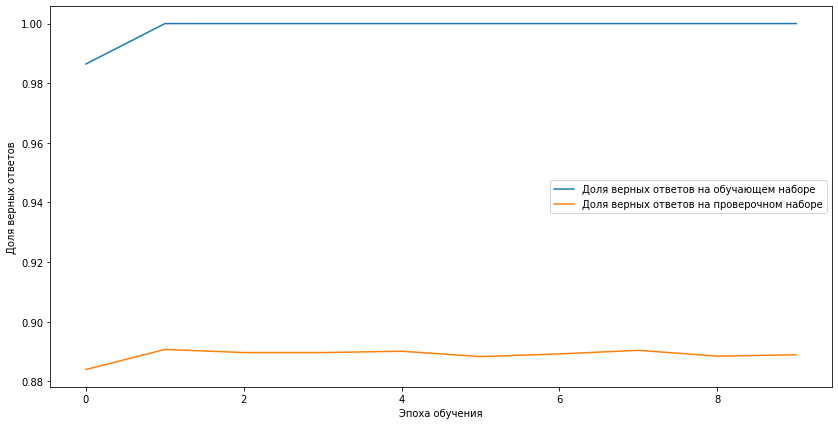

In [ ]:
# Выводим график обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()